In [1]:
import utils, json, umap, hdbscan, umap.plot
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from ast import literal_eval
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from transformers import pipeline

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/chunyuko/.cache/huggingface/token
Login successful


/Users/chunyuko/Documents/anaconda3/envs/py_3_11/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
keywords = ["數據科學", "資料科學", "數據工程", "資料工程", "資料庫", "演算法",
            "機器學習", "人工智慧", "人工智能", "數據分析", "自然語言", "電腦視覺",
            "資料分析", "商業分析", "產品分析", "data science",
            "data engineering", "database", "algorithm", "machine learning",
            "artificial intelligence", "natural language", "computer vision",
            "data analysis", "business analysis", "product analysis"]

path = "data/20231217_job_name.csv"

In [3]:
data = pd.read_csv(path)

In [4]:
def get_embedding(x):
    x = utils.get_splited_list(x, 2000)
    result = [utils.get_openai_embedding(i) for i in x]
    result = [i for j in result for i in j]
    result = [i.embedding for i in result]
    return result

In [5]:
embeddings = get_embedding(data.job_name.tolist())

In [6]:
job_name_classifier = CatBoostClassifier()
job_name_classifier.load_model("20231119_job_type_classifier")
job_name_classes = job_name_classifier.predict(embeddings).astype(bool)

In [7]:
dsa_job = data.\
    assign(embedding = embeddings,
           contain_keyword = lambda x: x.job_name.str.contains("|".join(keywords)),
           pred_contain_keyword = job_name_classes,
           months = lambda x: x.dates.apply(literal_eval)).\
    query("contain_keyword == True or pred_contain_keyword == True").\
    reset_index(drop = True).\
    filter(["id", "job_name", "embedding", "months", "times"])

In [8]:
monthly_count = dsa_job.\
    filter(["id", "months"]).\
    assign(times = lambda x: len(x.months)).\
    explode("months").\
    assign(month = lambda x: pd.to_datetime(x.months).dt.strftime("%Y-%m-01")).\
    groupby("month", as_index = False).\
    agg(count = ("id", "count"))

In [9]:
monthly_count["new"] = dsa_job.\
    filter(["id", "months"]).\
    assign(times = lambda x: len(x.months)).\
    explode("months").\
    groupby("id", as_index = False).\
    agg(month = ("months", "min")).\
    groupby("month", as_index = False).\
    agg(new = ("id", "count"))["new"]

In [10]:
monthly_count = monthly_count.\
    query("month >= '2023-02-01'")
monthly_count

,month,count,new
1,2023-02-01,956,956
2,2023-03-01,923,96
3,2023-04-01,950,126
4,2023-05-01,968,103
5,2023-06-01,955,83
6,2023-07-01,946,99
7,2023-08-01,927,118
8,2023-09-01,910,56
9,2023-10-01,892,83
10,2023-11-01,889,80


In [11]:
print("{:.0f}".format(monthly_count["count"].mean()), "{:.0f}".format(monthly_count["new"][1:].mean()))

929 93


In [12]:
px.line(monthly_count,
        x = "month", y = "count", text = "count",
        markers = True, width = 600, height = 400,
        labels = dict(title="Legend Title"),
        title = "Monthly Taipei DSA Job Openings<br><sup>From Feb. to Dec. 2023, there is an average of 930 job openings each month,<br>with only 93 new positions added monthly in Taipei city, Taiwan.</sup>").\
    add_bar(x=monthly_count["month"][1:], y=monthly_count["new"][1:], text = monthly_count["new"][1:], name="New Vacancies").\
    update_layout(template="plotly_white", hovermode="x unified").\
    update_xaxes(title="Month").\
    update_yaxes(title="Job Vacancies", tickformat=",")

In [13]:
reduced_embeddings = umap.UMAP(n_neighbors=50).fit(np.array(dsa_job.embedding.tolist()))
dsa_job["type"] = hdbscan.HDBSCAN(min_cluster_size = 50).fit_predict(reduced_embeddings.embedding_)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: >

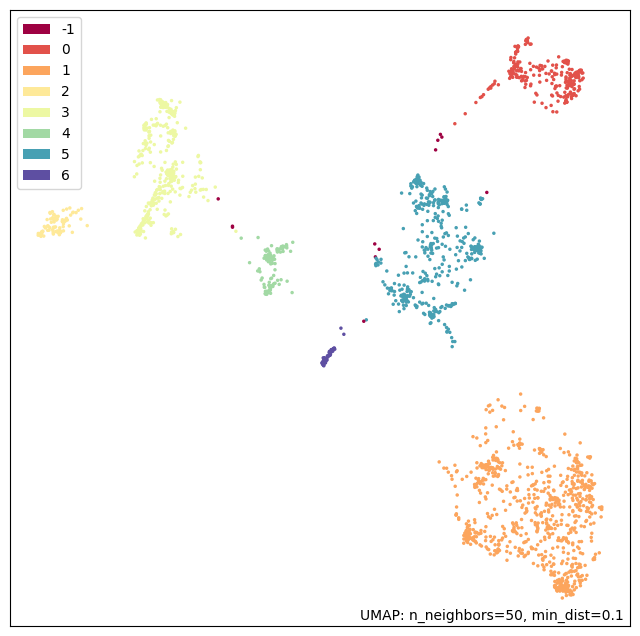

In [14]:
umap.plot.points(reduced_embeddings, labels = np.array(dsa_job["type"].tolist()))

In [15]:
dsa_job.groupby("type", as_index = False).agg(count = ("id", "count"), text = ("job_name", lambda x: [x]))

,type,count,text
0,-1,12,"[[ai/python engineer(圖像辨識/數據分析), 科技金融_資料科學家/深度..."
1,0,254,[[資深資料庫管理師 / senior database administrator (db...
2,1,787,"[[s.電子商務‧資料科學分析師, 資料科學分析師(總公司), hy- 美商知名日用品公司【..."
3,2,82,"[[sports data scientist (tensorflow, keras), s..."
4,3,335,"[[computer vision engineer-camera system, seni..."
5,4,105,"[[資料科學家/工程師, 科技金融_ai數據科學家, 資料科學家 (data scienti..."
6,5,412,"[[data engineer 數據工程師(台北總公司), 【採線上面談】senior da..."
7,6,53,"[[東南亞金融科技發展-數據工程師（數數發中心, ddt）, 資料科學工程師 （data s..."


In [16]:
zsclassifier = pipeline(model="facebook/bart-large-mnli")

https://www.bhef.com/publications/quant-crunch-how-demand-data-science-skills-disrupting-job-market

In [18]:
job_category = ["Data Analyst", "Data Scientist", "Data Engineer", "Algorithm Engineer"]
job_categories = zsclassifier(dsa_job["job_name"].to_list(), candidate_labels = job_category)

In [19]:
dsa_job["category"] = [i["labels"][0] for i in job_categories]

In [20]:
category_count = dsa_job.groupby(["category"], as_index=False).agg(count=("id", "count"))
category_count

,category,count
0,Algorithm Engineer,306
1,Data Analyst,754
2,Data Engineer,349
3,Data Scientist,631


In [21]:
category_count = dsa_job.groupby(["category"], as_index=False).agg(count=("id", "count"))

px.pie(category_count, values="count", names="category", title="Types of Job Titles", width=600, height=400, color_discrete_sequence=px.colors.qualitative.G10).\
    update_layout(template="plotly_white", hovermode="x unified")

In [22]:
dsa_job

,id,job_name,embedding,months,type,category
0,53ewp,s.電子商務‧資料科學分析師,"[-0.014193032868206501, -0.003473198739811778,...",[2023-02-03],1,Data Scientist
1,73ifb,data engineer 數據工程師(台北總公司),"[-0.02036551758646965, -0.014195398427546024, ...","[2023-12-02, 2023-10-01, 2023-07-01, 2023-08-1...",5,Data Engineer
2,74fxr,資料科學分析師(總公司),"[-0.019578883424401283, -0.0043485285714268684...","[2023-03-04, 2023-02-03]",1,Data Analyst
3,7aflo,"東南亞金融科技發展-數據工程師（數數發中心, ddt）","[-0.022152801975607872, -0.017860697582364082,...","[2023-02-03, 2023-03-04]",6,Data Scientist
4,7djse,hy- 美商知名日用品公司【業務部門-數據分析專員】(年薪$900k-$1.2m/台北市松山區),"[-0.02870860882103443, -0.0036438913084566593,...",[2023-02-03],1,Data Analyst
...,...,...,...,...,...,...
2035,7w1fm,總公司【資訊系統開發部】商業數據分析師(business analytics),"[-0.018296469002962112, -0.018665403127670288,...","[2023-07-01, 2023-11-04, 2023-03-04, 2023-12-0...",1,Data Analyst
2036,8060q,資料科學家,"[-0.006897732615470886, 0.0038703945465385914,...","[2023-07-01, 2023-11-04, 2023-10-01, 2023-08-1...",4,Data Scientist
2037,81ixt,pa1469 機器學習專家工程師/高級工程師(內湖),"[-0.017623040825128555, 0.007101411931216717, ...","[2023-12-02, 2023-08-13, 2023-11-04, 2023-10-0...",3,Data Analyst
2038,85s7s,中階資料庫設計管理師,"[-0.007525148801505566, -0.016867900267243385,...",[2023-12-02],0,Data Analyst


In [23]:
monthly_count_type = dsa_job.\
    filter(["id", "category", "months"]).\
    assign(times = lambda x: len(x.months)).\
    explode("months").\
    assign(month = lambda x: pd.to_datetime(x.months).dt.strftime("%Y-%m-01")).\
    groupby(["id", "category"], as_index = False).\
    agg(month = ("months", "min")).\
    groupby(["month", "category"], as_index = False).\
    agg(new = ("id", "count")).\
    query("month >= '2023-03-01'")

In [24]:
import plotly.express as px

area_chart = px.area(monthly_count_type,
                    x="month",
                    y="new",
                    color="category",
                    title="Monthly Job Openings by Type",
                    labels={"month": "Month", "new": "Job Openings", "category": ""},
                    width=900, height=600, color_discrete_sequence=px.colors.qualitative.G10).\
    update_layout(template="plotly_white", hovermode="x unified",
                  legend=dict(yanchor="top",y=1.0,xanchor="left",x=0.2, orientation="h"))

area_chart.show()


In [25]:
monthly_count_type.pivot(index='month', columns='category', values='new')

category,Algorithm Engineer,Data Analyst,Data Engineer,Data Scientist
month,,,,
2023-03-04,14,36,7,39
2023-04-08,22,51,17,36
2023-05-07,12,34,14,43
2023-06-03,10,33,17,23
2023-07-01,12,45,14,28
2023-08-13,12,48,21,37
2023-09-02,7,23,12,14
2023-10-01,18,31,11,23
2023-11-04,11,22,18,29


In [26]:
fill_time = dsa_job.\
    filter(["id", "category", "months"]).\
    assign(times = lambda x: len(x.months)).\
    explode("months").\
    assign(month = lambda x: pd.to_datetime(x.months).dt.strftime("%Y-%m-01")).\
    groupby(["id", "category"], as_index = False).\
    agg(month_min = ("months", "min"),
        count = ("month", "count")).\
    query("month_min >= '2023-03-01' and month_min <= '2023-10-01'").\
    groupby(["category"], as_index = False).\
    agg(count = ("id", "count"),
        wait = ("count", lambda x: sum(x>1)))
fill_time["rate"] = fill_time["wait"] / fill_time["count"]

In [27]:
px.bar(fill_time, x='rate', y='category', orientation='h', title='Job Vacancies Unfilled for Over 1 Months',
       color = "category",
        labels={'rate': 'Rate %', 'category': 'Category'},
        width=600, height=400, color_discrete_sequence=px.colors.qualitative.G10).\
    update_layout(template="plotly_white", hovermode="x unified", showlegend = False).\
    update_xaxes(title="% Unfilled for > 1 Months", tickformat=".0%").\
    update_yaxes(title="Job Vacancies")


In [28]:
category_count.\
    assign(new = monthly_count_type.groupby("category", as_index = False).agg(count = ("new", "mean"))["count"],
           rate = fill_time["rate"])

,category,count,new,rate
0,Algorithm Engineer,306,13.1,0.841121
1,Data Analyst,754,35.6,0.737542
2,Data Engineer,349,14.7,0.796460
3,Data Scientist,631,29.6,0.847737


In [29]:
dsa_job

,id,job_name,embedding,months,type,category
0,53ewp,s.電子商務‧資料科學分析師,"[-0.014193032868206501, -0.003473198739811778,...",[2023-02-03],1,Data Scientist
1,73ifb,data engineer 數據工程師(台北總公司),"[-0.02036551758646965, -0.014195398427546024, ...","[2023-12-02, 2023-10-01, 2023-07-01, 2023-08-1...",5,Data Engineer
2,74fxr,資料科學分析師(總公司),"[-0.019578883424401283, -0.0043485285714268684...","[2023-03-04, 2023-02-03]",1,Data Analyst
3,7aflo,"東南亞金融科技發展-數據工程師（數數發中心, ddt）","[-0.022152801975607872, -0.017860697582364082,...","[2023-02-03, 2023-03-04]",6,Data Scientist
4,7djse,hy- 美商知名日用品公司【業務部門-數據分析專員】(年薪$900k-$1.2m/台北市松山區),"[-0.02870860882103443, -0.0036438913084566593,...",[2023-02-03],1,Data Analyst
...,...,...,...,...,...,...
2035,7w1fm,總公司【資訊系統開發部】商業數據分析師(business analytics),"[-0.018296469002962112, -0.018665403127670288,...","[2023-07-01, 2023-11-04, 2023-03-04, 2023-12-0...",1,Data Analyst
2036,8060q,資料科學家,"[-0.006897732615470886, 0.0038703945465385914,...","[2023-07-01, 2023-11-04, 2023-10-01, 2023-08-1...",4,Data Scientist
2037,81ixt,pa1469 機器學習專家工程師/高級工程師(內湖),"[-0.017623040825128555, 0.007101411931216717, ...","[2023-12-02, 2023-08-13, 2023-11-04, 2023-10-0...",3,Data Analyst
2038,85s7s,中階資料庫設計管理師,"[-0.007525148801505566, -0.016867900267243385,...",[2023-12-02],0,Data Analyst


In [32]:
dsa_job.filter(["id", "category"]).to_csv("data/20231217_job_category.csv", index = False)